# Prize-Collecting Steiner Trees
## Imports

In [95]:
# Import standard libraries
from importlib import reload
import csv
import OmicsIntegrator as oi
import pandas as pd
import numpy as np
import scipy.stats as ss
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tqdm
import time

# Import custom libraries
import neighborhoods as nbh
import pcst_utils_2 as pcst

In [160]:
# Reload modules in case of modifications
reload(nbh)
reload(pcst)

<module 'pcst_utils_2' from '/home/braunger/masterthesis/python_code/PCST/pcst_utils_2.py'>

In [56]:
# File paths
data_dir = "/home/braunger/masterthesis/data/"
save_dir = "/home/braunger/masterthesis/save/pcst/"
fig_dir = "/home/braunger/masterthesis/save/figures/pcst/"

## Preliminary Analyses about the TFs

In [223]:
# Load TF-target interactions
tf_targets = pd.read_csv(data_dir + 'tf_data/tf-target-information.txt', sep = '\t')
tf_targets = tf_targets[['TF', 'target']].drop_duplicates()

# filter TF-target interactions to the ones included in STRING
# since hTF also includes non-protein-coding genes
PPI = pd.read_csv(data_dir + 'ppi_data/PPI_string_physical.csv', sep = '\t')
proteins = set(PPI['protein1']).union(set(PPI['protein2']))
tf_targets = tf_targets[tf_targets['TF'].isin(proteins)]
tf_targets = tf_targets[tf_targets['target'].isin(proteins)]

n_TFs = len(set(tf_targets['TF']))
print(str(n_TFs) + " TFs from hTFtarget are included in STRING.")

482 TFs from hTFtarget are included in STRING.


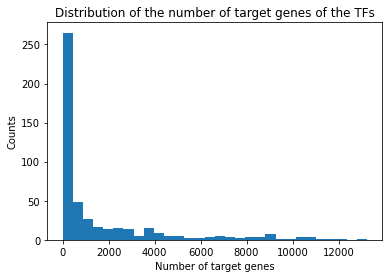

In [146]:
TF_counts = pd.DataFrame(tf_targets['TF'].value_counts())

# Histogram of number of targets
plt.figure()
plt.hist(TF_counts['TF'], bins = 30)
plt.xlabel("Number of target genes")
plt.ylabel("Counts")
plt.title("Distribution of the number of target genes of the TFs")
plt.savefig(fig_dir+"hist_n_targets.png")
plt.show()

<font color='red'>Do we want to filter out those that have too many targets?</font>

# PCST 

In [147]:
# Graph hyperparameters
graph_params =  {
                "w": 2,
                "b": 2,
                "g": 0,
                "noise": 0.0, 
                "dummy_mode": "terminals", 
                "exclude_terminals": False, 
                "seed": 1,
                "pruning": 'strong',
                "verbosity_level": 0
                }

In [162]:
augmented_forest = pcst.run_pcst_combi("0_10_20", graph_params, data_dir, save_dir, "all", "top10")

Build the graph


01:49:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
01:49:45 - OI2: INFO - []
01:49:45 - OI2: INFO - Members of the prize file not present in the interactome:
01:49:45 - OI2: INFO - ['AFAP1_tr0', 'APLN_tr0', 'BBLN_tr0', 'C11orf96_tr0', 'C12orf56_tr0', 'C15orf48_tr0', 'C19orf33_tr0', 'C1orf54_tr0', 'C4orf47_tr0', 'CCDC190_tr0', 'CCDC3_tr0', 'CFAP251_tr0', 'FAM162B_tr0', 'FOXL2NB_tr0', 'GASK1B_tr0', 'GPR63_tr0', 'GSTT1_tr0', 'H2AC6_tr0', 'IHO1_tr0', 'IRAG1_tr0', 'KIAA0040_tr0', 'LCNL1_tr0', 'MACROH2A2_tr0', 'METTL24_tr0', 'MGP_tr0', 'NALF1_tr0', 'NPY4R_tr0', 'OR2W3_tr0', 'PARM1_tr0', 'PIGZ_tr0', 'SPEGNB_tr0', 'ST6GALNAC2_tr0', 'TAMALIN_tr0', 'TCEAL7_tr0', 'TGFBR3L_tr0', 'THSD1_tr0', 'TMEM130_tr0', 'TMEM233_tr0', 'TMEM52_tr0', 'TMSB15B_tr0', 'TRABD2A_tr0', 'TRNP1_tr0', 'VSIG10L_tr0', 'XKR5_tr0', 'ZNF883_tr0']


Run PCST
Done


In [149]:
# Save network to file
oi.output_networkx_graph_as_interactive_html(augmented_forest, filename=save_dir + "network_0_10_20.html")
oi.output_networkx_graph_as_pickle(augmented_forest, filename= save_dir + "network_0_10_20.pickle")

PosixPath('/home/braunger/masterthesis/save/pcst/network_0_10_20.pickle')

# Analyses of the results

### General numbers of the network

In [150]:
# Number of nodes and edges
n_nodes = augmented_forest.number_of_nodes()
n_edges = augmented_forest.number_of_edges()
print('The augmented forest has ' + str(n_nodes) + ' nodes and ' + str(n_edges) + ' edges.')

# Included terminals
prizes_data = pd.read_csv(save_dir+'de_terminals_0_10_20.tsv', sep='\t')
terminals = set(prizes_data['name'].tolist())
network_df = oi.get_networkx_graph_as_dataframe_of_nodes(augmented_forest)
n_included_terminals = np.sum(network_df['terminal'])
percentage_terminals = n_included_terminals/len(terminals) * 100
print(str(n_included_terminals) +" of the "+str(len(terminals))+ " prized proteins (" + str(round(percentage_terminals,1)) +"%) and "+str(n_nodes-n_included_terminals)+" Steiner nodes are included.\n")

# Not-included terminals
not_incl_terminals = list(terminals.difference(network_df.index.tolist()))
prizes_not_included = prizes_data[prizes_data['name'].isin(not_incl_terminals)]
print("Prized proteins that are not included (mean prize: " + str(round(np.mean(prizes_not_included['prize']),2)) + ", min prize: " + str(round(np.min(prizes_not_included['prize']),2)) + ", max prize: "+str(round(np.max(prizes_not_included['prize']),2))+"): ")
print(*[gene.split('_', 1)[0] for gene in not_incl_terminals], sep = ", ")

The augmented forest has 3402 nodes and 79739 edges.
2385 of the 2438 prized proteins (97.8%) and 1017 Steiner nodes are included.

Prized proteins that are not included (mean prize: 0.8, min prize: 0.47, max prize: 1.93): 
CCDC3, CFAP251, NPY4R, FOXL2NB, ST6GALNAC2, C15orf65, NALF1, TRNP1, MGP, CCDC190, GSTT1, OR2W3, C11orf96, IRAG1, C12orf56, THSD1, CALHM6, TRABD2A, METTL24, PARM1, ZNF883, KRTAP3-1, FAM162B, IHO1, APLN, LCNL1, C4orf47, MACROH2A2, TAMALIN, CALHM3, C1orf54, PIK3IP1, VSIG10L, CLDND2, GASK1B, TMEM52, H2AC6, XKR5, C19orf33, SPEGNB, C15orf48, TMEM119, TCEAL7, TMSB15B, PIGZ, BBLN, TMEM233, TMEM130, AFAP1, GLYATL1, TGFBR3L, GPR63, KIAA0040


### Included TFs

In [151]:
# how many of the TFs are in the network?
n_TFs_not_incl = len(set(tf_targets['TF']+"_tr0").difference(set(augmented_forest.nodes())))
print("Out of the "+str(n_TFs)+" TFs "+str(n_TFs - n_TFs_not_incl)+" TFs are included and "+str(n_TFs_not_incl)+" are not included.")

Out of the 482 TFs 246 TFs are included and 236 are not included.


In [152]:
# TFs 
TFs = list(set(tf_targets['TF']))
TF_df = network_df[network_df.index.isin([TF + "_tr0" for TF in TFs])]
TF_df.head(n = 10)

,prize,terminal,type,degree,betweenness,louvain_clusters
RNF2_tr0,0.000000,False,protein,1081,0.002357,2
HNF4G_tr0,0.000000,False,protein,209,0.000111,2
ZNF263_tr0,0.000000,False,protein,652,0.002538,2
ETS2_tr0,0.000000,False,protein,243,0.000272,2
OTX2_tr0,0.000000,False,protein,274,0.000198,2
CENPA_tr0,0.000000,False,protein,912,0.000408,3
HOXA6_tr0,0.000000,False,protein,116,0.000042,2
ATF3_tr0,1.684959,True,protein,708,0.010306,2
KDM4C_tr0,0.000000,False,protein,418,0.000975,2
PAX6_tr0,0.659535,True,protein,464,0.000287,3


In [194]:
TF_df[TF_df['terminal'] == True].shape

(34, 6)

### Self-redundancy between TFs

In [154]:
# Self-redundancy
TFs_incl = [TF[:-4] for TF in TF_df.index.tolist()]
tf_self_targets = tf_targets[tf_targets['target'].isin(TFs_incl)]
print(str(len(TFs_incl))+ " TFs are included in the network and there are "+ str(tf_self_targets.shape[0]) + " edges between the selected TFs." )

246 TFs are included in the network and there are 13648 edges between the selected TFs.


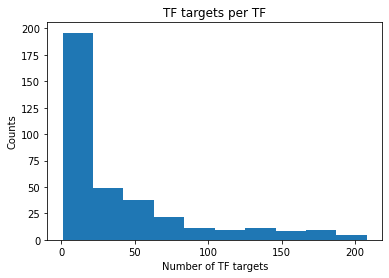

In [155]:
plt.figure()
plt.hist(pd.DataFrame(tf_self_targets['TF'].value_counts())['TF'])
plt.title('TF targets per TF')
plt.xlabel("Number of TF targets")
plt.ylabel("Counts")
plt.show()

In [156]:
tf_self_targets['TF'].value_counts()

MAZ         208
FLI1        201
EP300       198
BRD4        198
CREB1       195
           ... 
MED1          1
TOP1          1
CASP8AP2      1
MBD2          1
POU5F1        1
Name: TF, Length: 358, dtype: int64

### Included TF target interactions

In [157]:
# Network nodes:
nodes = pd.DataFrame(augmented_forest.nodes)[0].str.split("_", expand=True)
nodes.columns = ['protein', 'transition']
# Save nodes for analysis on STRING website (supports only networks up to 2000 nodes)
nodes['protein'].to_csv(save_dir+"nodes_0_10_20.txt", sep = "\n", index = False, header = False)

# TF-target interactions that are included in the network:
incl_tf_targets = tf_targets[tf_targets['TF'].isin(TFs_incl)]
incl_tf_targets = incl_tf_targets[incl_tf_targets['target'].isin(nodes[nodes['transition'] == "tr1"]['protein'])]

# Number of targets
target_counts = pd.DataFrame(incl_tf_targets['TF'].value_counts()).join(TF_counts, lsuffix = "_incl_targets", rsuffix = "_all_targets")

In [219]:
target_counts

,TF_incl_targets,TF_all_targets,fibroblasts,all_targets_percent,p_value,significance,log2_fc
MAZ,858,13235,True,0.719919,6.688366e-04,p < 0.05,0.000000
FLI1,743,11954,False,0.650239,2.467331e-01,p > 0.05,0.000000
CTCF,703,10174,True,0.553416,7.033832e-07,p < 0.05,0.000000
EP300,672,11139,True,0.605907,7.324767e-01,p > 0.05,0.000000
HDAC2,639,10543,False,0.573488,6.567208e-01,p > 0.05,0.000000
...,...,...,...,...,...,...,...
CBX2,1,4,False,0.000218,2.171426e-01,p > 0.05,-0.647549
EED,1,37,False,0.002013,8.963234e-01,p > 0.05,0.000000
SIRT6,1,31,False,0.001686,8.502265e-01,p > 0.05,0.000000
SMAD4,1,10,False,0.000544,4.577953e-01,p > 0.05,0.000000


In [158]:
# TF-target interactions in fibroblasts
TFs_fibroblasts = set(pd.read_csv(data_dir + 'tf_data/tftarget_full_processed.csv', sep = '\t')['tf'])
target_counts['fibroblasts'] = np.where(target_counts.index.isin(TFs_fibroblasts), True, False)

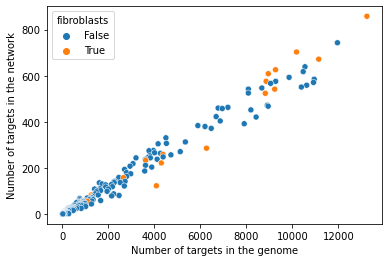

In [159]:
plt.figure()
sns.scatterplot(x='TF_all_targets', y='TF_incl_targets', data=target_counts, hue='fibroblasts')
plt.xlabel('Number of targets in the genome')
plt.ylabel('Number of targets in the network')
plt.savefig(fig_dir+"n_targets.png")
plt.show()

### Significant TFs

In [198]:
target_counts['all_targets_percent'] = target_counts['TF_all_targets'] / 18384
n = nodes[nodes['transition'] == "tr1"].shape[0]
target_counts['p_value'] = target_counts.apply(lambda x: ss.binomtest(k = x['TF_incl_targets'], 
                                        n = n, 
                                        p = x['all_targets_percent'], 
                                        alternative= 'greater').pvalue, axis=1)

In [192]:
target_counts[target_counts['p_value'] < 0.05].sort_values(by=['p_value'])#.shape[0]

,TF_incl_targets,TF_all_targets,fibroblasts,all_targets_percent,p_value
CTCF,703,10174,True,0.553416,7.033832e-07
CDK8,136,1603,False,0.087195,8.156731e-05
NFIC,331,4497,False,0.244615,8.395478e-05
FOSL1,244,3196,False,0.173847,1.218864e-04
SPI1,609,8948,True,0.486728,1.392072e-04
CEBPB,626,9262,True,0.503808,2.282527e-04
ASCL1,305,4157,False,0.226121,2.306418e-04
ESR1,275,3762,False,0.204634,6.675517e-04
MAZ,858,13235,True,0.719919,6.688366e-04
EZH2,68,746,False,0.040579,9.318083e-04


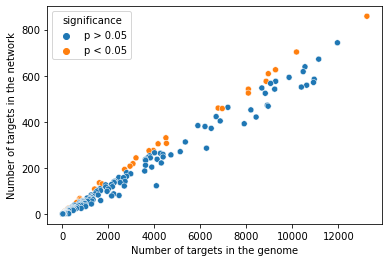

In [218]:
# Coloring according to significance
target_counts['significance'] = np.where(target_counts['p_value'] < 0.05, 'p < 0.05', 'p > 0.05')

plt.figure()
sns.scatterplot(x='TF_all_targets', y='TF_incl_targets', data=target_counts, 
                hue='significance', hue_order = ['p > 0.05', 'p < 0.05'])
plt.xlabel('Number of targets in the genome')
plt.ylabel('Number of targets in the network')
plt.savefig(fig_dir+"n_targets_significance.png")
plt.show()

### Sign of the TFs and targets

In [256]:
# Load differentially expressed genes
de_genes = pd.read_csv(data_dir+'de_data/fc_top10.csv')

# Log2 fold change of the TFs
de_tfs = de_genes.loc[(de_genes['transition'] == "fc_0_10") & (de_genes['gene'].isin(target_counts.index))][['gene', 'log2_fc']]
de_tfs.columns = ['TF', 'TF_log2_fc']

# Log2 fold change of the targets
de_genes = de_genes.loc[de_genes['transition'] == "fc_10_20"][['gene', 'log2_fc']]
de_genes.columns = ['target', 'target_log2_fc']

# TF target interactions with log2 fold changes
fc_tf_targets = de_tfs.merge(tf_targets, on = 'TF').merge(de_genes, how = 'inner', on = 'target')
fc_tf_targets

,TF,TF_log2_fc,target,target_log2_fc
0,MYH11,-3.611351,CELF2,1.212672
1,MITF,-1.921036,CELF2,1.212672
2,FOS,-0.649341,CELF2,1.212672
3,CEBPB,0.482755,CELF2,1.212672
4,MYH11,-3.611351,DDIT4,-1.142059
...,...,...,...,...
4156,CEBPB,0.482755,ACKR4,2.124405
4157,CEBPB,0.482755,CSF2RB,1.250423
4158,CEBPB,0.482755,CLEC2B,0.669899
4159,CEBPB,0.482755,HOXA13,0.454379


In [286]:
augmented_forest

In [299]:
group_dict = {node: nodes.loc[nodes['name'] == node, 'category'].values[0] for node in augmented_forest.nodes()}

In [300]:
group_dict

{'S100A13_tr0': 'Steiner node',
 'ENO1_tr0': 'Steiner node',
 'MAEL_tr1': 'DE_tr1',
 'GINS1_tr0': 'Steiner node',
 'SUSD3_tr1': 'DE_tr1',
 'APOB_tr0': 'Steiner node',
 'PM20D2_tr1': 'DE_tr1',
 'MYO1F_tr1': 'DE_tr1',
 'CARD9_tr0': 'DE_tr0',
 'MUC13_tr1': 'DE_tr1',
 'RNF144B_tr0': 'DE_tr0',
 'GNG8_tr0': 'DE_tr0',
 'LAMC2_tr0': 'DE_tr0',
 'FN1_tr0': 'Steiner node',
 'TSPAN18_tr1': 'DE_tr1',
 'TNNC2_tr0': 'DE_tr0',
 'STXBP6_tr0': 'DE_tr0',
 'RAB3B_tr1': 'DE_tr1',
 'ITPR1_tr0': 'DE_tr0',
 'MAPK8_tr0': 'Steiner node',
 'PCDH10_tr1': 'DE_tr1',
 'TBX2_tr0': 'DE_tr0',
 'BIRC3_tr1': 'DE_tr1',
 'SHISAL1_tr0': 'DE_tr0',
 'PRNP_tr0': 'Steiner node',
 'ACTL10_tr1': 'DE_tr1',
 'CASP8_tr0': 'Steiner node',
 'ARHGEF37_tr1': 'DE_tr1',
 'RNF2_tr0': 'Steiner node',
 'TSPAN18_tr0': 'DE_tr0',
 'PRKG2_tr1': 'DE_tr1',
 'DCN_tr1': 'DE_tr1',
 'ITGA9_tr0': 'Steiner node',
 'MME_tr1': 'DE_tr1',
 'KCNMB4_tr0': 'DE_tr0',
 'DCC_tr0': 'DE_tr0',
 'PRSS23_tr0': 'DE_tr0',
 'NNAT_tr0': 'DE_tr0',
 'KRT19_tr1': 'DE_tr1',
 